# Variational Autoencoders

In this assignment you will implement autoencoder (AE), variational autoencoder (VAE), conditional variational autoencoder (CVAE) and a simple feed-forward neural network (NN).
You will train these models on MNIST dataset, compare the results and make some conclusions about the comparison and about each model separately.
The conclusions are mandatory.

The required theory is below.
The literature list is also available for those who want to further extend their knowledge about VAE.

In this assignment the use of torch.distributions, torch.logsumexp and other standard libraries with distributions density, reparametrization trick and KL-divergence is prohibited.

# Theory

## Variational Autoencoder

### Problem setting

A set of independent and identically distributed samples from true data distribtuion is given: $x_i \sim p_d(x)$, $i = 1, \dots, N$.

The problem is to build a probabilistic model $p_\theta(x)$ of the true data distribution $p_d(x)$.

The model $p_\theta(x)$ must be able to estimate probabilistic density function (p. d. f.) for given $x$ and to sample $x \sim p_\theta(x)$.

### Probabilistic model
$z \in \mathbb{R}^d$ is a latent variable.

The generative process of VAE:
1. Sample $z \sim p(z)$.
2. Sample $x \sim p_\theta(x | z)$.

The parameters of distribution $p_\theta(x | z)$ are obtained using a neural network with weights $\theta$ and $z$ as an input.
This network is called generator or decoder.

The above generative process induce the following model p. d. f. for $x$:

$$p_\theta(x) = \mathbb{E}_{z \sim p(z)} p_\theta(x | z)$$

### Model parameterization

A priori distribution on the latent varibales is standard normal distribution: $p(z) = \mathcal{N}(z | 0, I)$.

The distributions on the components of $x$ are conditionally independent given $z$: $p_\theta(x | z) = \prod\limits_{i = 1}^D p_\theta(x_i | z)$.

If i-th component is real-valued, we can use Gaussian generative distribution: $p_\theta(x_i | z) = \mathcal{N}(x_i | \mu_i(z, \theta), \sigma^2_i(z, \theta))$.
Here $\mu(z, \theta)$ и $\sigma(z, \theta)$ are deterministic functions defined by neural networks with parameters $\theta$.

If i-th component is categorial, then we can use categorical generative distribution: $p_\theta(x_i | z) = Cat(Softmax(\omega_i(z, \theta)))$, where $\omega_i(z, \theta)$ is also a deterministic function described by neural network.

Binary components are the special case of categorical ones. For them categorical distribution turns into Bernoulli distibution with just one parameter.

_Tip:_ some pixels are black in the whole MNIST train set, so likelihood maximization forces the probability of these pixels to be black to 1.
Therefore the weights for these pixels tend to become closer to infinity.
To avoid divergence of the training procedure, we may add a clipping level into generative network: e. g. clipping layer into range $[-10, 10]$ before final activation.

### Variational lower bound

To fit the model to data we maximize marginal log-likelihood $\log p_\theta(x)$ of the train set.

Nevertheless, $\log p_\theta(x)$ cannot be optimized straightforwardly, because there is integral in high-dimensional space inside the logarithm which cannot be computed analytically or numerically estimated with enough accuracy in a reasonable amount of time.

So to perform optimization we maximize the _variational lower bound_ (VLB) on log-likelihood instead:
$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi(z | x)} \log p_\theta(x) = 
\mathbb{E}_{z \sim q_\phi(z | x)} \log \frac{p_\theta(x, z) q_\phi(z | x)}{q_\phi(z | x) p_\theta(z | x)} = 
\mathbb{E}_{z \sim q_\phi(z | x)} \log \frac{p_\theta(x, z)}{q_\phi(z | x)} + KL(q_\phi(z | x) || p_\theta(z | x))$$
$$\log p_\theta(x) \geqslant \mathbb{E}_{z \sim q_\phi(z | x)} \log \frac{p_\theta(x | z)p(z)}{q_\phi(z | x)} = 
\mathbb{E}_{z \sim q_\phi(z | x)} \log p_\theta(x | z) - KL(q_\phi(z | x) || p(z)) = L(x; \phi, \theta)
\to \max\limits_{\phi, \theta}$$

$q_\phi(z | x)$ is called a proposal, recognition or variational distribution. It is ususally defined as a Gaussian with parameters from a neural network with weights $\phi$ which takes $x$ as an input:
$q_\phi(z | x) = \mathcal{N}(z | \mu_\phi(x), \sigma^2_\phi(x)I)$.
Usually neural network defines $\log\sigma_\phi(x)$ or $\log(\exp(\sigma_\phi(x) - 1))$ instead of $\sigma_\phi(x)$. So $\sigma_\phi(x)$ is always positive by design and also more scale-independent. We use $\log(\exp(\sigma_\phi(x) - 1))$ in this assignment because its reverse transition is Softplus and behaves more stable for big positive preactivations than Exp.

#### Discussion of VLB

One can show that the gap between VLB $L(x; \phi, \theta)$ on log-likelihood and the log-likelihood $\log p_\theta(x)$ itself is KL-divergence between proposal and aposteriori distributions over $z$: $KL(q_\phi(z | x) || p_\theta(z | x))$.
Maximum of $L(x; \phi, \theta)$ with fixed $\theta$ is achieved when $q_\phi(z | x) = p_\theta(z | x)$.
Nevertheless, $p_\theta(z | x)$ is untractable, so instead of numerically computing it, VLB is optimized w. r. t. $\phi$ using backpropagation and reparameterization trick (see below).
The closer $q_\phi(z | x)$ to $p_\theta(z | x)$, the more precise is VLB.
The true posterior distribution $p_\theta(z | x)$ often cannot be decribed by one Gaussian, so the gap between VLB and LL never reaches zero.

The first term of VLB - $\mathbb{E}_{z \sim q_\phi(z | x)} \log p_\theta(x | z)$ - is called reconstruction loss.
The model describes this term is an autoencoder with one stochastic layer which tries to restore input object $x$.
If $q_\phi(z | x)$ is a delta-function, then an aoutoencoder with a stochastic layer turns into an ordinary autoencoder.
That is why $q_\phi(z | x)$ and $p_\theta(x | z)$ are called encoder and decoder respectivelly.

The term $KL(q_\phi(z | x) || p(z))$ is called regularizer.
It forces $z \sim q_\phi(z | x)$ to be close to $0$.
But, as described above, it also forces $q_\phi(z | x)$ to be close to $p_\theta(z | x)$, which is even more important.
Somebody use a coefficient before KL-divergence or even a different regularizer.
Naturally, after that optimization of VLB usually becomes unrelated to the log-likelihood of the initial probabilistic model.
This decreases intrpretability of the model and avoids theoretical guarantees.

KL-divergence between two Gaussians can be computed analytically, which improves the speed and stability of optimization procedure.

#### Reparameterization trick
We use stochastic gradient ascent in order to maximize $L(x; \phi, \theta)$.

The gradient of KL-divergence w. r. t. $\phi$ can be derived analytically as well as KL-divergence itself in the case of two Gaussians.

The gradient of the reconstruction loss w. r. t. $\theta$ is computed using backpropagation.
$$\frac{\partial}{\partial \theta} L(x; \phi, \theta) = \mathbb{E}_{z \sim q_\phi(z | x)} \frac{\partial}{\partial \theta} \log p_\theta(x | z)$$

The gradient of the reconstruction loss w. r. t. $\phi$ can be computed using reparametrization trick:
$$\varepsilon \sim \mathcal{N}(\varepsilon | 0, I)$$
$$z = \mu + \sigma \varepsilon \Rightarrow z \sim \mathcal{N}(z | \mu, \sigma^2I)$$
$$\frac{\partial}{\partial \phi} L(x; \phi, \theta) = \mathbb{E}_{\varepsilon \sim \mathcal{N}(\varepsilon | 0, I)} \frac{\partial}{\partial \phi} \log p_\theta(x | \mu_\phi(x) + \sigma_\phi(x) \varepsilon) - \frac{\partial}{\partial \phi} KL(q_\phi(z | x) || p(z))$$

_Tip:_ the main trick in deriving KL-divergence between two Gaussians is to never write the integral sign.
We consider only Gaussians with diagonal covariation matrix, so it comes to derive KL-divergence between two one-dimensional Gaussians.
All you need to derive the formula:
$$KL(q || p) = \mathbb{E}_{z \sim q} \log\frac{q(z)}{p(z)}$$
$$\mathrm{N}(z | \mu, \sigma^2) = \frac{1}{\sqrt{2\pi}\sigma} \exp \left(-\frac{(z - \mu)^2}{2\sigma^2} \right)$$
$$\mathbb{E}_{z \sim N(\mu, \sigma)}z = \mu$$
$$\mathbb{E}_{z \sim N(\mu, \sigma)}z^2 = \mu^2 + \sigma ^ 2$$
Btw, the above equations have multidimensional generalizations.

### Log-likelihood estimation

Model log-likelihood $\log p_\theta(x) = \log \mathbb{E}_{z \sim p(z)} p_\theta(x | z)$ is estimated using the hold-out validation set.

Likelihood can be estimated using Monte-Carlo method:

$$z_i \sim p(z), i = 1, \dots, K$$
$$p_\theta(x) \approx \frac{1}{K} \sum\limits_{i = 1}^K p_\theta(x | z_i)$$

An alternative is importance sampling method.
We use the proposal distribution from model as the proposal distribution.
The good choice of the proposal distribution is known to decrease the estimate variance for importance sampling.

For VAE, Monte-Carlo with a small amount of samples underestimates true log-likelihood.
Imporatance sampling allows estimating likelihood for VAE more precisely with a small amount of samples.

$$z_i \sim q_\phi(z | x), i = 1, \dots, K$$
$$p_\theta(x) = \mathbb{E}_{z \sim p(z)} p_\theta(x | z) = \mathbb{E}_{z \sim q_\phi(z | x)} \frac{p_\theta(x | z) p(z)}{q_\phi(z | x)} \approx \frac{1}{K} \sum\limits_{i = 1}^K \frac{p_\theta(x | z_i) p(z_i)}{q_\phi(z_i | x)}$$

The both above estimates are unbiased, but also useless for us.
First, likelihood density in a high-dimensional space usually too small to be handled by floating point computer arithmetics.
Second, even after likelihood estimation for one object we have to multiply these estimations to get the likelihood of the whole validation set.

So instead of likelihood we estimate log-likelihood for each object which allows us to avoid numerical unstability.

For log-likelihood estimation the averaging is also performed inside the logarithm:
$$\log p_\theta(x) \approx \log \frac{1}{K} \sum\limits_{i = 1}^K p_\theta(x | z_i),\,\,\,\,z_i \sim p(z)$$
$$\log p_\theta(x) \approx \log \frac{1}{K} \sum\limits_{i = 1}^K \frac{p_\theta(x | z_i) p(z_i)}{q_\phi(z_i | x)},\,\,\,\,z_i \sim q_\phi(z | x)$$
Note that these etimates are not unbiased.
Nevertheless, the first estimate is referred sometimes as Monte-Carlo log-likelihood estimate.
The second estimate is known as IWAE estimate for the paper Importance Weighted Variational Autoencoders which proposes to directly optimize this estimate for learning VAE.

### References
1. Auto-Encoding Variational Bayes https://arxiv.org/pdf/1312.6114.pdf, Stochastic Backpropagation and Approximate Inference in Deep Generative Models https://arxiv.org/pdf/1401.4082.pdf - the original papers on VAE (two research groups independently and almost simultaneusly proposed the same model).
2. Learning Structured Output Representation using Deep Conditional Generative Models https://papers.nips.cc/paper/5775-learning-structured-output-representation-using-deep-conditional-generative-models.pdf - conditional VAE for sampling from conditional distributions.
3. Importance Weighted Autoencoders https://arxiv.org/pdf/1509.00519.pdf - variational autoencoder which optimizes more accurate lower bound on log-likelihood.
4. Tighter Variational Bounds are Not Necessarily Better https://arxiv.org/pdf/1802.04537.pdf - the paper which shows that the tighter lower bound from the previous paper leads to the proposal networks underfitting and proposes the ways to solve the problem.
5. Doubly Reparameterized Gradient Estimators for Monte Carlo Objectives https://openreview.net/forum?id=HkG3e205K7 - the paper which proposes variance reduction optimization procedure which also solves the problem from the paper above.
6. Variational Inference with Normalizing Flows https://arxiv.org/pdf/1505.05770.pdf, Improved Variational Inference with Inverse Autoregressive Flow http://papers.nips.cc/paper/6581-improved-variational-inference-with-inverse-autoregressive-flow.pdf - richer families of the proposal distributions based on flows.
7. VAE with a VampPrior https://arxiv.org/pdf/1705.07120.pdf - learning the prior distribution on the latent variable together with the proposal one. Improves model log-likelihood but makes the latent space less interpretable.
8. Ladder Variational Autoencoders http://papers.nips.cc/paper/6275-ladder-variational-autoencoders.pdf - now an object has not only one latent representation but a hierarchy of them.
9. Inference Suboptimality in Variational Autoencoders https://arxiv.org/pdf/1801.03558.pdf - the paper states that the gap between VLB and log-likelihood is more due to the lack of proposal network capacity than due to the poor proposal distributions family. Nevertheless, richer proposal distributions family soften the requirements to the network capacity.

# Practice
Let's do some practice!

## Dataset

In [1]:
import torchvision
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch import nn
from torch import optim

In [2]:
data = MNIST('mnist', download=True, train=True)
train_data_raw = TensorDataset(data.train_data.view(-1, 28 * 28).float() / 255, data.train_labels)
train_data = TensorDataset(train_data_raw.tensors[0].round())
data = MNIST('mnist', download=True, train=False)
test_data_raw = TensorDataset(data.test_data.view(-1, 28 * 28).float() / 255, data.test_labels)
test_data = TensorDataset(test_data_raw.tensors[0].round())

100%|██████████| 9912422/9912422 [00:00<00:00, 100416661.62it/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 49768156.87it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 27598653.55it/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7395391.60it/s]


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



/opt/conda/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/opt/conda/lib/python3.10/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/opt/conda/lib/python3.10/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/opt/conda/lib/python3.10/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


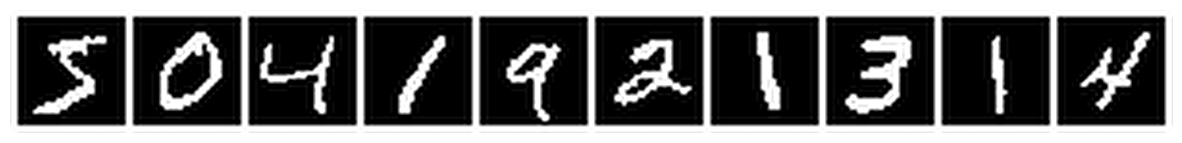

In [16]:
from matplotlib import pyplot as plt
%matplotlib inline

def show_images(x, scale=15, line_width=10):
    plt.figure(figsize=(scale, scale / line_width * (x.shape[0] // line_width + 1)))
    x = x.view(-1, 1, 28, 28)
    mtx = torchvision.utils.make_grid(x, nrow=line_width, pad_value=1)
    plt.imshow(mtx.permute([1, 2, 0]).numpy(), cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
    plt.axis('off')

show_images(train_data[:10][0])

## Utils

In [17]:
import sys
if sys.version_info[0] < 3:
    raise Exception("Must be using Python 3")

if sys.version_info[1] >= 7:
    from contextlib import nullcontext
else:
    class nullcontext:
        def __init__(self, enter_context=None):
            self.enter_context = enter_context

        def __enter__(self):
            return self.enter_context

        def __exit__(self, *args, **kwargs):
            return None

from tqdm import tqdm as tqdm

In [18]:
def test_loss(compute_loss, data, batch_size=128, num_samples=None, verbose=False):
    """
    Computes averaged loss function over the test data.
    Input: compute_loss, function of batch (type torch.FloatTensor),
           returns single float - loss function on the batch.
    Input: data, Dataset - for testing.
    Input: batch_size, int.
    Input: num_samples, int - if set, then stop computing
           after processing num_samples objects. Otherwise
           compute loss function over the whole test set.
    Input: verbose, bool - whether to print the progress.
    Return: float - the loss function estimate.
    """
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=(num_samples is None))
    samples_processed = 0
    avg_loss = 0
    raw_iterator = enumerate(dataloader)
    with (tqdm(raw_iterator, total=len(dataloader)) if verbose else nullcontext(raw_iterator)) as iterator:
        for i, batch in iterator:
            samples_processed += int(batch[0].shape[0])
            if len(batch) == 1:
                batch = batch[0]
            loss = compute_loss(batch)
            avg_loss += (loss - avg_loss) / (i + 1)
            if verbose:
                iterator.set_description('Test loss: %.3f' % avg_loss)
            if num_samples and samples_processed >= num_samples:
                break
    return avg_loss

In [35]:
def train_model(parameters, batch_loss, data, tests=[], maximization=True,
                tests_per_epoch=5, batch_size=64, num_epochs=5,
                learning_rate=1e-3):
    """
    Perfrom stochastic gradient descent or ascent over batch_loss
    function and stores the learning progress.
    Input: batch_loss - fucntion of batch which returns
           differentiabale loss scalar tensor.
    Input: data, Dataset - for training.
    Input: tests - a list of tests performed during the optimization.
           Each list element is a dictionary with two fields:
           'name' is an unique identifier of the test,
           'func' is a test function with no parameters.
    Input: maximization, bool - whether to maximize batch_loss or
           to minimize.
    Input: tests_per_epoch, int.
    Input: batch_size, int.
    Input: num_epochs, int.
    Input: learning_rate, float.
    Return: a dictionary with fileds
            'train_losses_list' - a list of batch loss values on
                                  every batch
            'test_results' -      a dictionary of pairs
                                  <test_name>: <list of the test results>
            'num_epochs' -        number of epochs
    """
    gd = optim.Adam(parameters, lr=learning_rate)

    train_losses = []
    test_results = {test['name']: [] for test in tests}

    for epoch in range(num_epochs):
        dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
        num_batches_between_tests = len(dataloader) // tests_per_epoch + 1
        avg_train_loss = 0
    
        with tqdm(enumerate(dataloader), total=len(dataloader)) as iterator:
            for batch_num, batch in iterator:
                if len(batch) == 1:
                    batch = batch[0]
                gd.zero_grad()
                loss = batch_loss(batch)
                if maximization:
                    (-loss).backward()
                else:
                    loss.backward()
                gd.step()

                train_losses.append(float(loss))            

                avg_train_loss += (float(loss) - avg_train_loss) / (batch_num + 1)
                iterator.set_description('Train loss: %.3f' % avg_train_loss)

                if batch_num % num_batches_between_tests == 0 or \
                        (epoch == num_epochs - 1 and batch_num == len(iterator) - 1):
                    for test in tests:
                        test_results[test['name']].append(test['func']())
    return {
        'train_losses_list': train_losses,
        'test_results': test_results,
        'num_epochs': num_epochs,
    }

In [28]:
n = 15
digit_size = 28

from scipy.stats import norm
import numpy as np

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

def draw_manifold(generator):
    figure = np.zeros((digit_size * n, digit_size * n))
    for i, yi in enumerate(reversed(grid_x)):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])

            x_decoded = generator(z_sample)
            digit = x_decoded
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
    plt.axis('off')
    plt.show()

In [29]:
def draw_latent_space(data, target, encoder):
    z_test = encoder(data)
    plt.figure(figsize=(7, 6))
    plt.scatter(z_test[:, 0], z_test[:, 1], c=target, cmap='gist_rainbow', alpha=0.75)
    plt.colorbar()
    plt.show()

In [30]:
from sklearn.manifold import TSNE

In [31]:
def get_ticks(num_points, num_epochs):
    return np.arange(num_points) / (num_points - 1) * num_epochs

def draw_line(points, num_epochs, label):
    plt.plot(get_ticks(len(points), num_epochs), points, label=label)

def smooth_line(points, chunk_size=10):
    res = []
    for i in range((len(points) - 1) // chunk_size + 1):
        chunk = points[i * chunk_size: (i + 1) * chunk_size]
        res.append(sum(chunk) / len(chunk))
    return res

## Autoencoder

In [44]:
class AE(nn.Module):
    def __init__(self, d, D):
        """
        Initialize model weights.
        Input: d, int - the dimensionality of the latent space.
        Input: D, int - the dimensionality of the object space.
        """
        super(type(self), self).__init__()
        self.d = d
        self.D = D
        self.encoder = nn.Sequential(
            nn.Linear(self.D, 200),
            nn.LeakyReLU(),
            nn.Linear(200, self.d)
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.d, 200),
            nn.LeakyReLU(),
            nn.Linear(200, self.D),
            nn.Sigmoid(),
        )

    def encode(self, x):
        """
        Generate a latent code given the objects.
        Input: x, Tensor of shape n x D.
        Return: Tensor of shape n x d.
        """
        return self.encoder(x)

    def decode(self, z):
        """
        Generate objects given the latent representations.
        Input: z, Tensor of shape n x d - the latent representations.
        Return: Tensor of shape n x D.
        """
        return self.decoder(z)

    def batch_loss(self, batch):
        """
        Compute batch loss. Batch loss is an average of per-object losses.
        Per-object loss is a sum of reconstruction L2-error and
        L2-regularization of the latent representations.
        Tip: do not average average per-pixel L2-errors for the object, use
        their sum instead. Also do not average L2-reguralization for
        the components in the latent space.
        The returned scalar must be differentiable w. r. t. the weights
        of the model. (!)
        Input: batch, Tensor of shape n x D.
        Return: Tensor, scalar - loss function for the batch.
        """
        z = self.encoder(batch)
        out = self.decoder(z)
        
        reconstruction_loss = torch.sum((batch - out)**2, dim=-1)
        reguralization_loss = torch.sum(z**2, dim=-1)
        
        loss = torch.mean(reconstruction_loss + reguralization_loss)
        return loss

    def generate_samples(self, num_samples):
        """
        Generate samples from standard normal distribution in the latent space.
        Input: num_samples, int - number of sample to be generated.
        Return: Tensor of shape num_samples x D.
        """
        samples = torch.randn(num_samples, self.d)
        generate_samples = self.decoder(samples)
        return generate_samples

### Training models

In [45]:
ae_tests = lambda model: [
    {
        'name': 'test_loss',
        'func': lambda: test_loss(lambda batch:
                                  float(model.batch_loss(batch)),
                                  test_data,
                                  num_samples=1000, verbose=False)
    }
]

In [46]:
ae_d2 = AE(2, 784)
ae_d2_train_log = train_model(ae_d2.parameters(), ae_d2.batch_loss, train_data, tests=ae_tests(ae_d2), 
                            maximization=False, num_epochs=25)

Train loss: 45.449: 100%|██████████| 938/938 [00:05<00:00, 173.89it/s]


In [47]:
ae_d10 = AE(10, 784)
ae_d10_train_log = train_model(ae_d10.parameters(), ae_d10.batch_loss, train_data, tests=ae_tests(ae_d10),
                             maximization=False, num_epochs=25)

Train loss: 22.527: 100%|██████████| 938/938 [00:05<00:00, 169.25it/s]


### Evaluating results

Visual inspection

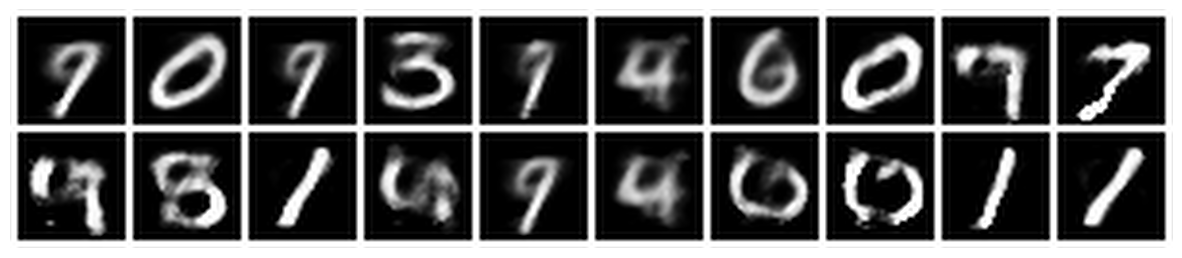

In [48]:
show_images(ae_d2.generate_samples(20).detach())

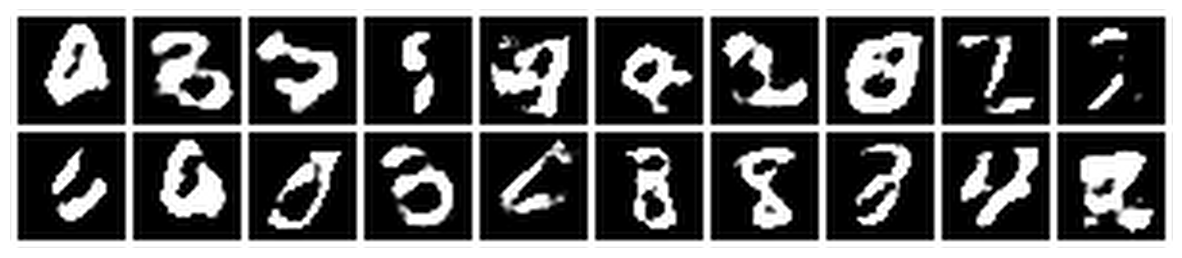

In [49]:
show_images(ae_d10.generate_samples(20).detach())

Latent space visualization (from the decoder's side)

In [50]:
def draw_manifold_ae(model):
    generator = lambda z: model.decode(torch.from_numpy(z).float()).view(28, 28).data.numpy()
    return draw_manifold(generator)

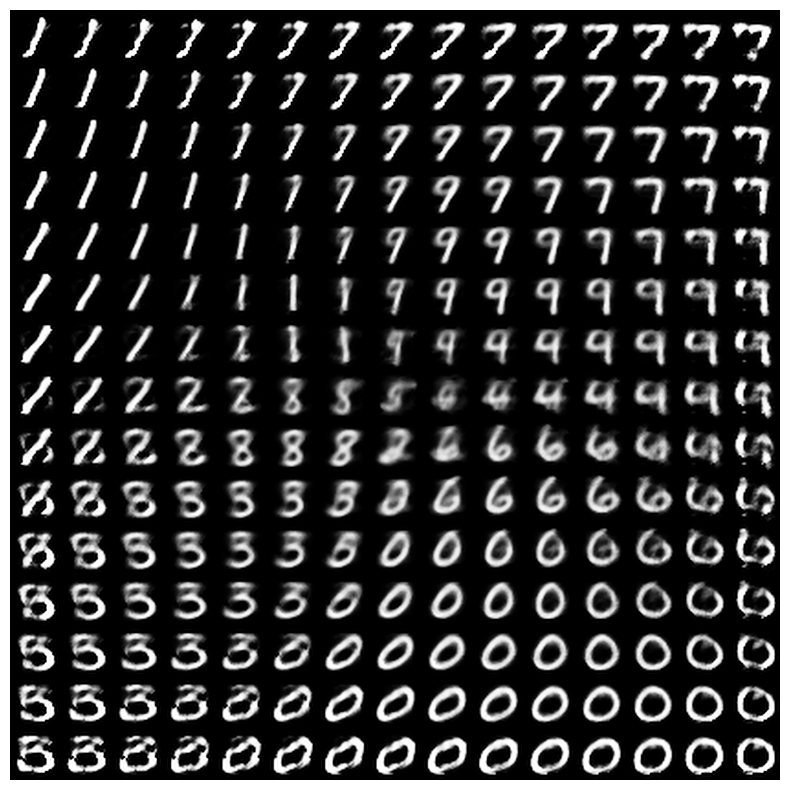

In [51]:
draw_manifold_ae(ae_d2)

Latent space visualization (from the encoder's side)

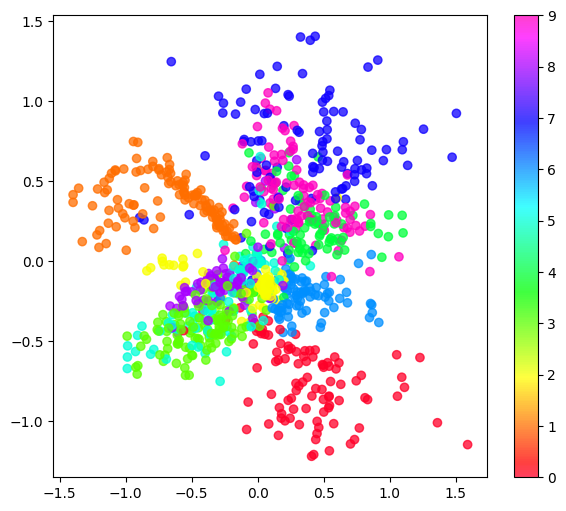

In [52]:
draw_latent_space(test_data_raw.tensors[0][::10], test_data_raw.tensors[1][::10],
                  lambda data: ae_d2.encode(data).detach())

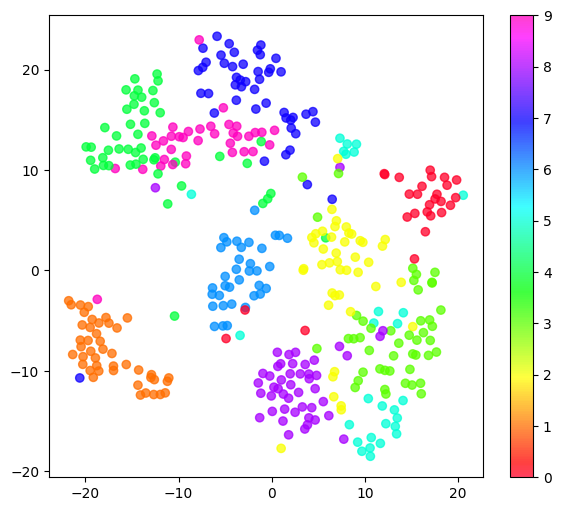

In [53]:
ae_encoder_d10 = lambda data: TSNE().fit_transform(ae_d10.encode(data).data.numpy())
draw_latent_space(test_data_raw.tensors[0][::25], test_data_raw.tensors[1][::25], ae_encoder_d10)

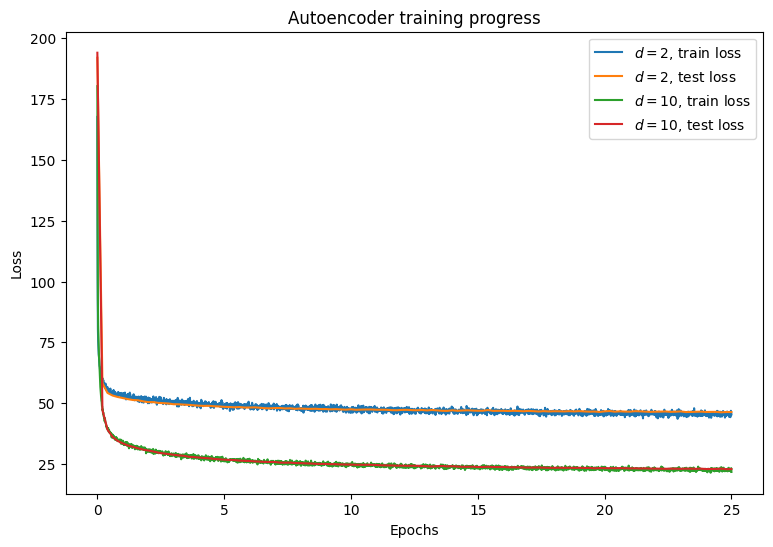

In [54]:
plt.figure(figsize=(9, 6))
plt.title('Autoencoder training progress')
plt.xlabel('Epochs')
plt.ylabel('Loss')
draw_line(smooth_line(ae_d2_train_log['train_losses_list']), ae_d2_train_log['num_epochs'], '$d=2$, train loss')
draw_line(ae_d2_train_log['test_results']['test_loss'], ae_d2_train_log['num_epochs'], '$d=2$, test loss')
draw_line(smooth_line(ae_d10_train_log['train_losses_list']), ae_d10_train_log['num_epochs'], '$d=10$, train loss')
draw_line(ae_d10_train_log['test_results']['test_loss'], ae_d10_train_log['num_epochs'], '$d=10$, test loss')
plt.legend()

## Probabilistic utils

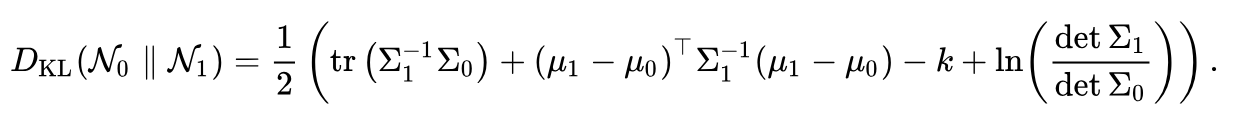

In [65]:
def bernoulli_log_likelihood(x_true, x_distr):
    """
    Compute log-likelihood of objects x_true for the generated by model
    component-wise Bernoulli distributions.
    Each object from x_true has K corresponding distrbutions from x_distr.
    Log-likelihood estimation must be computed for each pair of an object
    and a corresponding to the object distribution.
    Do not forget about computational stability!
    Do not divide log-likelihood by the dimensionality of the space of objects.

    Input: x_true, Tensor of shape n x D.
    Input: x_distr, Tensor of shape n x K x D - parameters of component-wise
           Bernoulli distributions.
    Return: Tensor of shape n x K - log-likelihood for each pair of an object
            and a corresponding distribution.
    """
    n, D = x_true.shape
    log_likelihood = torch.log(torch.where(x_true.reshape(n, 1, D) > 0, x_distr, 1 - x_distr))
    return torch.sum(log_likelihood, dim=-1)


def kl(q_mu, q_sigma, p_mu, p_sigma):
    """
    
    Compute KL-divergence KL(q || p) between n pairs of Gaussians
    with diagonal covariational matrices.
    Do not divide KL-divergence by the dimensionality of the latent space.

    Input: q_mu, p_mu, Tensor of shape n x d - mean vectors for n Gaussians.
    Input: q_sigma, p_sigma, Tensor of shape n x d - standard deviation
           vectors for n Gaussians.
    Return: Tensor of shape n - each component is KL-divergence between
            a corresponding pair of Gaussians.
    """
    kl = 0.5 * ((q_sigma**2 + (q_mu - p_mu)**2) / (2 * p_sigma**2) - 0.5 + torch.log(p_sigma/q_sigma))
    return torch.sum(kl, dim=-1)

## Variational Autoencoder

In [66]:
class ClampLayer(nn.Module):
    def __init__(self, min=None, max=None):
        super().__init__()
        self.min = min
        self.max = max
        self.kwargs = {}
        if min is not None:
            self.kwargs['min'] = min
        if max is not None:
            self.kwargs['max'] = max

    def forward(self, input):
        return torch.clamp(input, **self.kwargs)

In [71]:
class VAE(nn.Module):
    def __init__(self, d, D):
        """
        Initialize model weights.
        Input: d, int - the dimensionality of the latent space.
        Input: D, int - the dimensionality of the object space.
        """
        super(type(self), self).__init__()
        self.d = d
        self.D = D
        self.proposal_network = nn.Sequential(
            nn.Linear(self.D, 200),
            nn.LeakyReLU(),
        )
        self.proposal_mu_head = nn.Linear(200, self.d)
        self.proposal_sigma_head = nn.Sequential(
            nn.Linear(200, self.d),
            nn.Softplus()
        )
        self.generative_network = nn.Sequential(
            nn.Linear(self.d, 200),
            nn.LeakyReLU(),
            nn.Linear(200, self.D),
            ClampLayer(-10, 10),
            nn.Sigmoid()
        )

    def proposal_distr(self, x):
        """
        Generate proposal distribution over z.
        Note that sigma is positive by design of neural network.
        Input: x, Tensor of shape n x D.
        Return: tuple(Tensor, Tensor),
                Each Tensor is a matrix of shape n x d.
                The first one is mu, the second one is sigma.
        """
        proposal = self.proposal_network(x)
        mu = self.proposal_mu_head(proposal)
        sigma = self.proposal_sigma_head(proposal)
        return mu, sigma

    def prior_distr(self, x):
        """
        Generate prior distribution over z.
        Note that sigma is positive by design of neural network.
        Input: x, Tensor of shape n x D.
        Return: tuple(Tensor, Tensor),
                Each Tensor is a matrix of shape n x d.
                The first one is mu, the second one is sigma.
        """
        mu = torch.zeros(x.shape[0], self.d)
        sigma = torch.ones(x.shape[0], self.d)
        return mu, sigma

    def sample_latent(self, mu, sigma, K=1):
        """
        Generate samples from Gaussians with diagonal covariance matrices in latent space.
        Samples must be differentiable w. r. t. parameters of distribution!
        Use reparametrization trick.
        Input: mu, Tensor of shape n x d - mean vectors for n Gaussians.
        Input: sigma, Tensor of shape n x d - standard deviation vectors
               for n Gaussians.
        Input: K, int - number of samples from each Gaussian.
        Return: Tensor of shape n x K x d.
        """
        n = mu.shape[0]
        epsilon = torch.randn([n, K, self.d], requires_grad=True)
        sigma_ = sigma.reshape(n, 1, self.d)
        return mu.reshape(n, 1, self.d) + epsilon * sigma_

    def generative_distr(self, z):
        """
        Compute a tensor of parameters of Bernoulli distribution over x
        given a tensor of latent representations.
        Input: z, Tensor of shape n x K x d - tensor of latent representations.
        Return: Tensor of shape n x K x D - parameters of Bernoulli distribution.
        """
        return self.generative_network(z)

    def batch_vlb(self, batch):
        """
        Compute VLB for batch. The VLB for batch is an average of VLBs for batch's objects.
        VLB must be differentiable w. r. t. model parameters, so use reparametrization!
        Input: batch, Tensor of shape n x D.
        Return: Tensor, scalar - VLB.
        """
        n = batch.shape[0]
        prior_mu, prior_sigma = self.prior_distr(batch)  
        proposal_mu, proposal_sigma = self.proposal_distr(batch) 
        z = self.sample_latent(proposal_mu, proposal_sigma) 
        out = self.generative_distr(z) 
        log_likelihood = bernoulli_log_likelihood(batch, out).reshape(n)
        kl_div = kl(proposal_mu, proposal_sigma, prior_mu, prior_sigma) 
        vlb = log_likelihood - kl_div
        vlb = torch.mean(vlb)
        return vlb

    def generate_samples(self, num_samples):
        """
        Generate samples from the model.
        Tip: for visual quality you may return the parameters of Bernoulli distribution instead
        of samples from it.
        Input: num_samples, int - number of samples to generate.
        Return: Tensor of shape num_samples x D.
        """
        prior_mu, prior_sigma = self.prior_distr(torch.empty(num_samples))
        z = self.sample_latent(prior_mu, prior_sigma)
        out = self.generative_distr(z).reshape(num_samples, self.D)
        samples = out
        return samples

### Log-likelihood estimates

In [78]:
def log_mean_exp(data):
    """
    Return log(mean(exp(data))) where mean is taken over the last dimension.
    Do not forget about computational stability!
    Using torch.logsumexp is prohibited!
    Input: data, Tensor of shape n_1 x n_2 x ... x n_K.
    Return: Tensor of shape n_1 x n_2 x ,,, x n_{K - 1}.
    """
    max_ = torch.max(data, dim=-1, keepdim=True).values
    log = max_.squeeze() + torch.log(torch.sum(torch.exp(data - max_), dim=-1))
    return log - np.log(data.shape[-1])

def gaussian_log_pdf(mu, sigma, samples):
    """
    Compute log-likelihood of samples for a given Gaussians with diagonal covariance matrices.
    Input: mu, Tensor of shape n x d - mean vectors for n Gaussians.
    Input: sigma, Tensor of shape n x d - standard deviation vectors for n Gaussians.
    Input: samples, Tensor of shape n x K x d.
    Return: Tensor of shape n x K - element (i, j) is log-likelihood of (i, j)-th sample
            w. r. t. i-th Gaussian.
    """
    n = samples.shape[0]
    d = samples.shape[2]
    log_pdf = -torch.log(sigma.reshape(n, 1, d)) - \
        (samples - mu.reshape(n, 1, d))**2 / (2 * sigma.reshape(n, 1, d)**2) - 0.5 * np.log(2 * np.pi)
    log_pdf =  torch.sum(log_pdf, dim=-1)
    return log_pdf


def compute_log_likelihood_monte_carlo(batch, model, generative_log_likelihood, K):
    """
    Monte-Carlo log-likelihood estimation for a batch.
    Log-likelihood must be averaged over all objects in the batch.
    Do not forget to convert the result into float! Otherwise the average of such results forms
    the computational graph stored in memory, which naturaly results in memory overflow soon enough.
    Input: batch, Tensor of shape n x D for VAE or pair of Tensors for CVAE
    Input: model, Module - object with methods prior_distr, sample_latent and generative_distr,
           described in VAE class.
    Input: generative_log_likelihood, function which takes batch and distribution parameters
           produced by the generative network.
    Input: K, int - number of latent samples.
    Return: float - average log-likelihood estimate for the batch.
    """
    prior_mu, prior_sigma = model.prior_distr(batch)  
    z = model.sample_latent(prior_mu, prior_sigma, K)  
    out = model.generative_distr(z) 
    log_likelihood_exp = generative_log_likelihood(batch, out) 
    log_likelihood = log_mean_exp(log_likelihood_exp) 
    ll =  float(torch.mean(log_likelihood))
    return ll

### Traning models

In [79]:
vae_tests = lambda model: [
    {
        'name': 'MC',
        'func': lambda:
                test_loss(lambda batch:
                                compute_log_likelihood_monte_carlo(batch, model, bernoulli_log_likelihood, K=10),
                          test_data,
                          num_samples=1000)
    }
]

In [80]:
vae_d2 = VAE(2, 784)
vae_d2_train_log = train_model(vae_d2.parameters(), vae_d2.batch_vlb, train_data,
                               tests=vae_tests(vae_d2), num_epochs=25)

Train loss: -142.097: 100%|██████████| 938/938 [00:06<00:00, 136.53it/s]


In [81]:
vae_d10 = VAE(10, 784)
vae_d10_train_log = train_model(vae_d10.parameters(), vae_d10.batch_vlb, train_data,
                                tests=vae_tests(vae_d10), num_epochs=25)

Train loss: -83.594: 100%|██████████| 938/938 [00:06<00:00, 139.94it/s]


### Evaluating results

Visual inspection

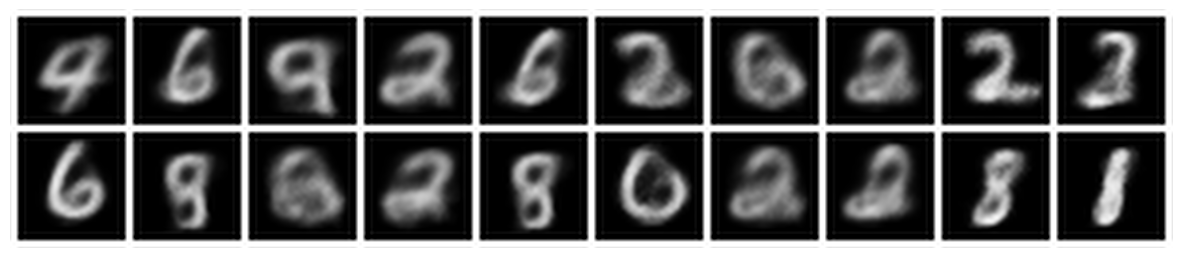

In [82]:
show_images(vae_d2.generate_samples(20).detach())

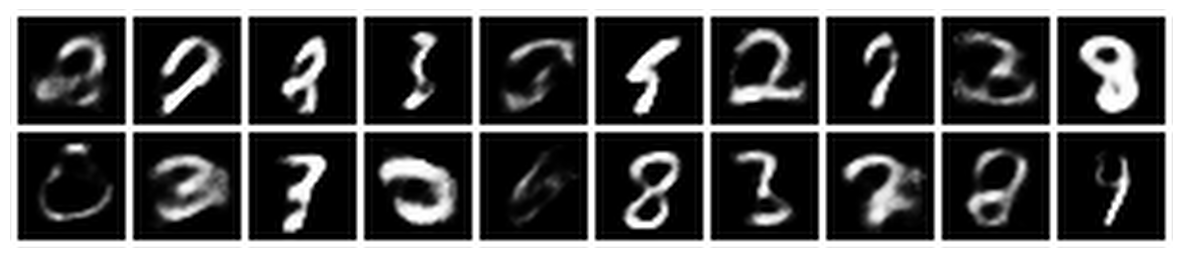

In [83]:
show_images(vae_d10.generate_samples(20).detach())

Latent space visualization (from the decoder's side)

In [84]:
def draw_manifold_vae(model):
    generator = lambda z: model.generative_distr(torch.from_numpy(z).unsqueeze(1).float()).view(28, 28).data.numpy()
    return draw_manifold(generator)

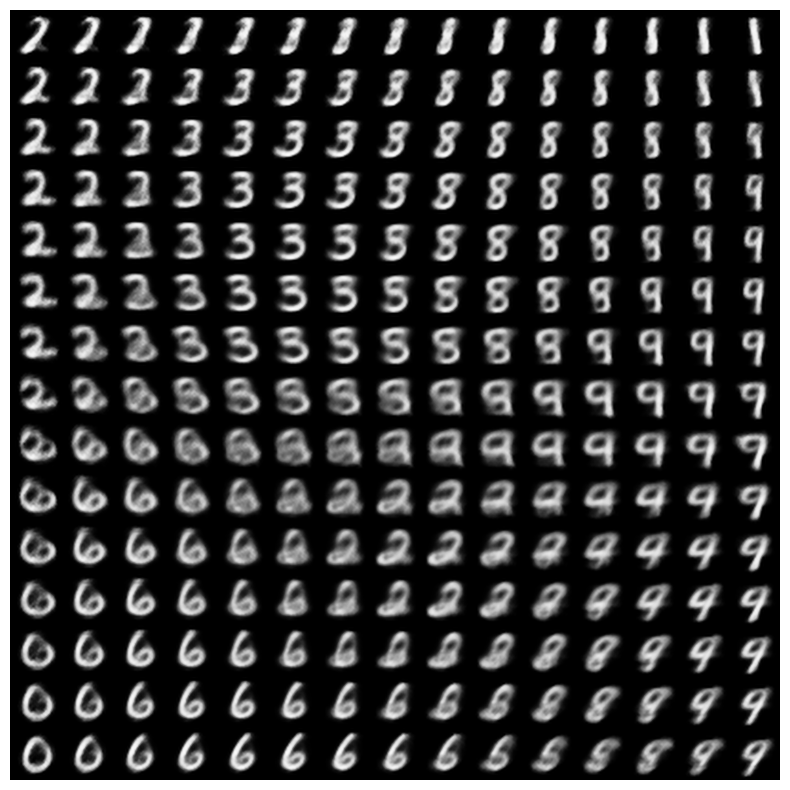

In [85]:
draw_manifold_vae(vae_d2)

Latent space visualization (from the encoder's side)

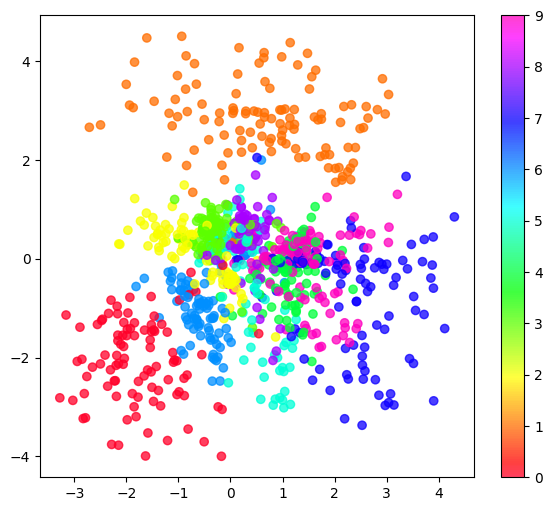

In [86]:
vae_encoder = lambda data, model: model.sample_latent(*model.proposal_distr(data))[:, 0].detach()
draw_latent_space(test_data_raw.tensors[0][::10], test_data_raw.tensors[1][::10],
                  lambda data: vae_encoder(data, vae_d2))

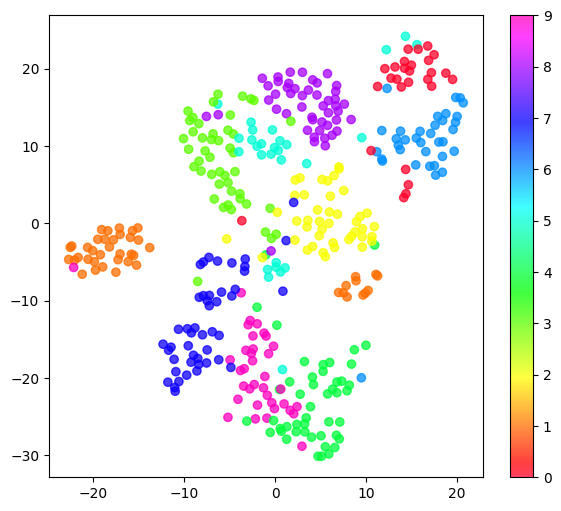

In [87]:
vae_encoder_d10 = lambda data: TSNE().fit_transform(vae_encoder(data, vae_d10).data.numpy())
draw_latent_space(test_data_raw.tensors[0][::25], test_data_raw.tensors[1][::25], vae_encoder_d10)

## The place for your conclusions
What is the difference between Autoencoder and Variational Autoencoder?

How does latent space dimensionality affect models?

What else can you say about models, learning progress, samples, log-likelihood estimates, latent spaces and representations?

Feel free to express your observations and hypoteses below!

1. Основное отличие между AE и VAE заключается в способе моделирования скрытого пространства. В AE это закодированные признаки(то есть конкретные значения), тогда как в VAE скрытое пространство моделируется статистическими параметрами, то есть работаем уже с распределениями, что позволяет генерировать новые данные, которых не было в трейне
2. Увеличение размерности скрытого пространства, ухудшает генерацию картинки. Хотя чем меньше размерность, тем больше сжимается исходный вектор и тем больше теряется информации. Следовательно генерация будет более скудная. Видимо из-за того, что картинки простые увеличение размерности оказалось хуже(менее интерпретируемо) 